# **Amazon Lookout for Equipment** - Demonstration on an anonymized expander dataset
*Part 4: Model evaluation*

## Initialization
---
Following the data preparation notebook, this repository should now be structured as follow:
```
/lookout-equipment-demo/getting_started/
|
├── data/
|   |
|   ├── labelled-data/
|   |   └── labels.csv
|   |
|   └── training-data/
|       └── expander/
|           ├── subsystem-01
|           |   └── subsystem-01.csv
|           |
|           ├── subsystem-02
|           |   └── subsystem-02.csv
|           |
|           ├── ...
|           |
|           └── subsystem-24
|               └── subsystem-24.csv
|
├── dataset/                                <<< Original dataset <<<
|   ├── labels.csv
|   ├── tags_description.csv
|   ├── timeranges.txt
|   └── timeseries.zip
|
├── notebooks/
|   ├── 1_data_preparation.ipynb
|   ├── 2_dataset_creation.ipynb
|   ├── 3_model_training.ipynb
|   ├── 4_model_evaluation.ipynb            <<< This notebook <<<
|   ├── 5_inference_scheduling.ipynb
|   └── config.py
|
└── utils/
    ├── aws_matplotlib_light.py
    └── lookout_equipment_utils.py
```

### Notebook configuration update

In [1]:
!pip install --quiet --upgrade tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Imports
<span style="color: white; background-color: OrangeRed; padding: 0px 15px 0px 15px; border-radius: 20px;">**Note:** Update the content of the **config.py** file **before** running the following cell</span>

In [2]:
import boto3
import config
import matplotlib.pyplot as plt
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import sys

# Helper functions for managing Lookout for Equipment API calls:
sys.path.append('../utils')
import lookout_equipment_utils as lookout

### Parameters

In [3]:
DATA            = os.path.join('..', 'data')
LABEL_DATA      = os.path.join(DATA, 'labelled-data')
REGION_NAME     = boto3.session.Session().region_name
DATASET_NAME    = config.DATASET_NAME
BUCKET          = config.BUCKET
PREFIX_TRAINING = config.PREFIX_TRAINING
PREFIX_LABEL    = config.PREFIX_LABEL
MODEL_NAME      = config.MODEL_NAME

In [4]:
# Loading time ranges:
timeranges_fname = os.path.join(DATA, 'timeranges.txt')
with open(timeranges_fname, 'r') as f:
    timeranges = f.readlines()
    
training_start   = pd.to_datetime(timeranges[0][:-1])
training_end     = pd.to_datetime(timeranges[1][:-1])
evaluation_start = pd.to_datetime(timeranges[2][:-1])
evaluation_end   = pd.to_datetime(timeranges[3][:-1])

print(f'Training period: from {training_start} to {training_end}')
print(f'Evaluation period: from {evaluation_start} to {evaluation_end}')

Training period: from 2015-01-01 00:00:00 to 2015-08-31 23:59:00
Evaluation period: from 2015-09-01 00:00:00 to 2015-11-30 23:59:00


### AWS Look & Feel definition for Matplotlib

In [5]:
%matplotlib inline

# Load style sheet:
plt.style.use('../utils/aws_matplotlib_light.py')

# Get colors from custom AWS palette:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Loading original datasets for analysis purpose

In [6]:
# Let's load all our original signals (they will be useful later on):
all_tags_fname = os.path.join(DATA, 'training-data', 'expander.parquet')
table = pq.read_table(all_tags_fname)
all_tags_df = table.to_pandas()
del table

## Model evaluation
---

The `DescribeModel` API can be used to extract, among other things, the metrics associated to the trained model:

In [7]:
lookout_client = lookout.get_client(region_name=REGION_NAME)
describe_model_response = lookout_client.describe_model(ModelName=MODEL_NAME)
list(describe_model_response.keys())

['ModelName',
 'ModelArn',
 'DatasetName',
 'DatasetArn',
 'Schema',
 'LabelsInputConfiguration',
 'TrainingDataStartTime',
 'TrainingDataEndTime',
 'EvaluationDataStartTime',
 'EvaluationDataEndTime',
 'RoleArn',
 'DataPreProcessingConfiguration',
 'Status',
 'TrainingExecutionStartTime',
 'TrainingExecutionEndTime',
 'ModelMetrics',
 'LastUpdatedTime',
 'CreatedAt',
 'ResponseMetadata']

The describe model response is a dictionnary. The `labeled_ranges` contains the label provided as an input while the `predicted_ranges` contains all the predicted ranges where Lookout for Equipment detected an anomaly. Let's use the following utility function get these into two dataframes:

In [8]:
LookoutDiagnostics = lookout.LookoutEquipmentAnalysis(model_name=MODEL_NAME, tags_df=all_tags_df, region_name=REGION_NAME)
LookoutDiagnostics.set_time_periods(evaluation_start, evaluation_end, training_start, training_end)
predicted_ranges = LookoutDiagnostics.get_predictions()
labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
labeled_range = LookoutDiagnostics.get_labels(labels_fname)

**Note:** the labeled range from the model Describe API, only provides any labelled data falling within the evaluation range. We use the original label data to get all of them.

Let's now display one of the original signal and map both the labeled and the predicted ranges on the same plot:

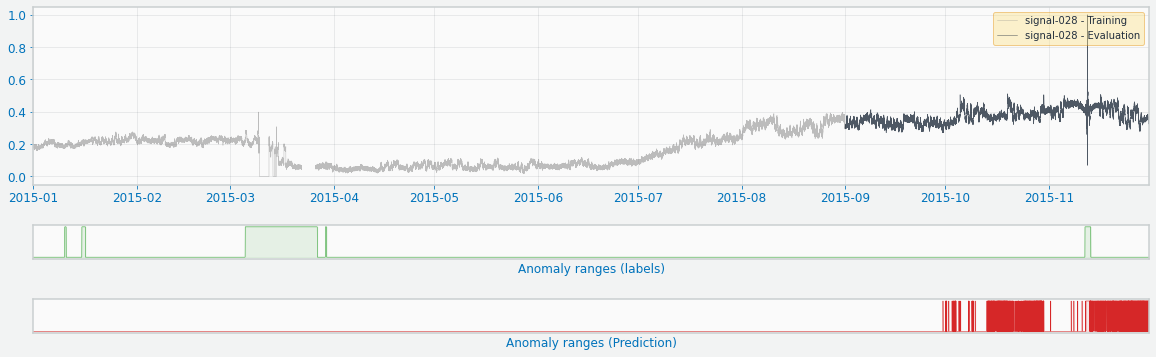

In [10]:
# We load the original signal we looked at in the data preparation step:
tag = 'signal-028'
tag_df = all_tags_df.loc[training_start:evaluation_end, [tag]]
tag_df.columns = ['Value']

# Plot all of that:
fig, axes = lookout.plot_timeseries(
    timeseries_df=tag_df, 
    tag_name=tag,
    fig_width=20, 
    tag_split=evaluation_start, 
    labels_df=labeled_range,
    predictions=predicted_ranges,
    custom_grid=False
)

## Diagnostics
---

Let's compare:
1. The signal values during the periods marked as **anomalies** in the **evaluation period**
2. The signal values deemed as normal during the **training period**

**We will plot two histograms** for each signal: one in red for the points marked as anomalies and another one in green for all the other normal datapoints. We will also compute a distance between these two distributions and rank them by decreasing order. The reasoning behind this comparison is to show which signals differ the most from their normal behavior when they are marked as anomalies by the model. This overview can point the customer SME towards the right directions to inspect a cause of anomaly.

Preparing histograms: 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]


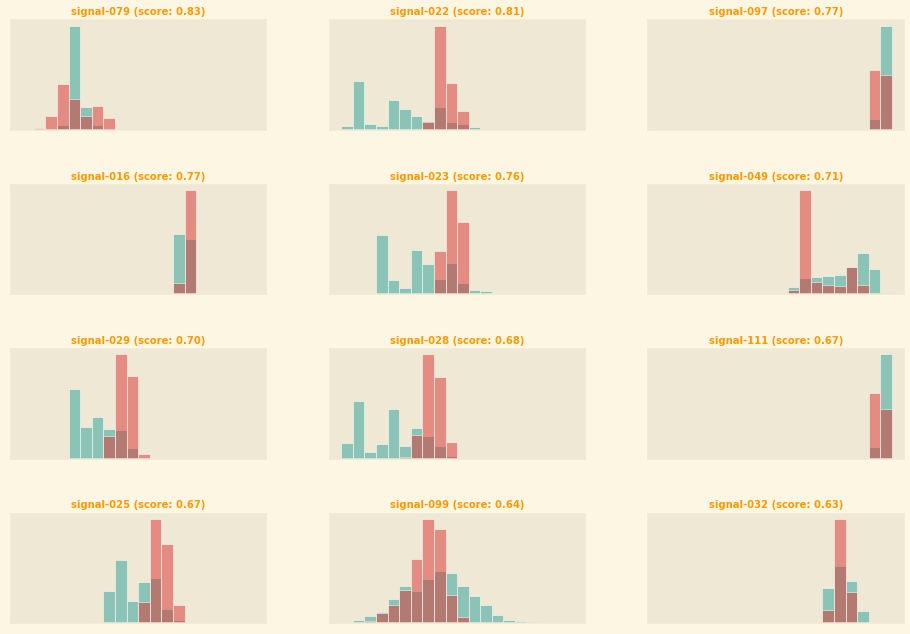

In [11]:
LookoutDiagnostics.compute_histograms()
fig, axes = LookoutDiagnostics.plot_histograms()

We can also plot the data points marked as anomalies directly on each time series signal:
* **In green**, the normal values during both the training and evaluation period
* **In red**, the values predicted as anomalies by the trained model
* **In grey**, the values marked as anomalies and excluded by the training to capture the asset behavior when it's operating under normal conditions

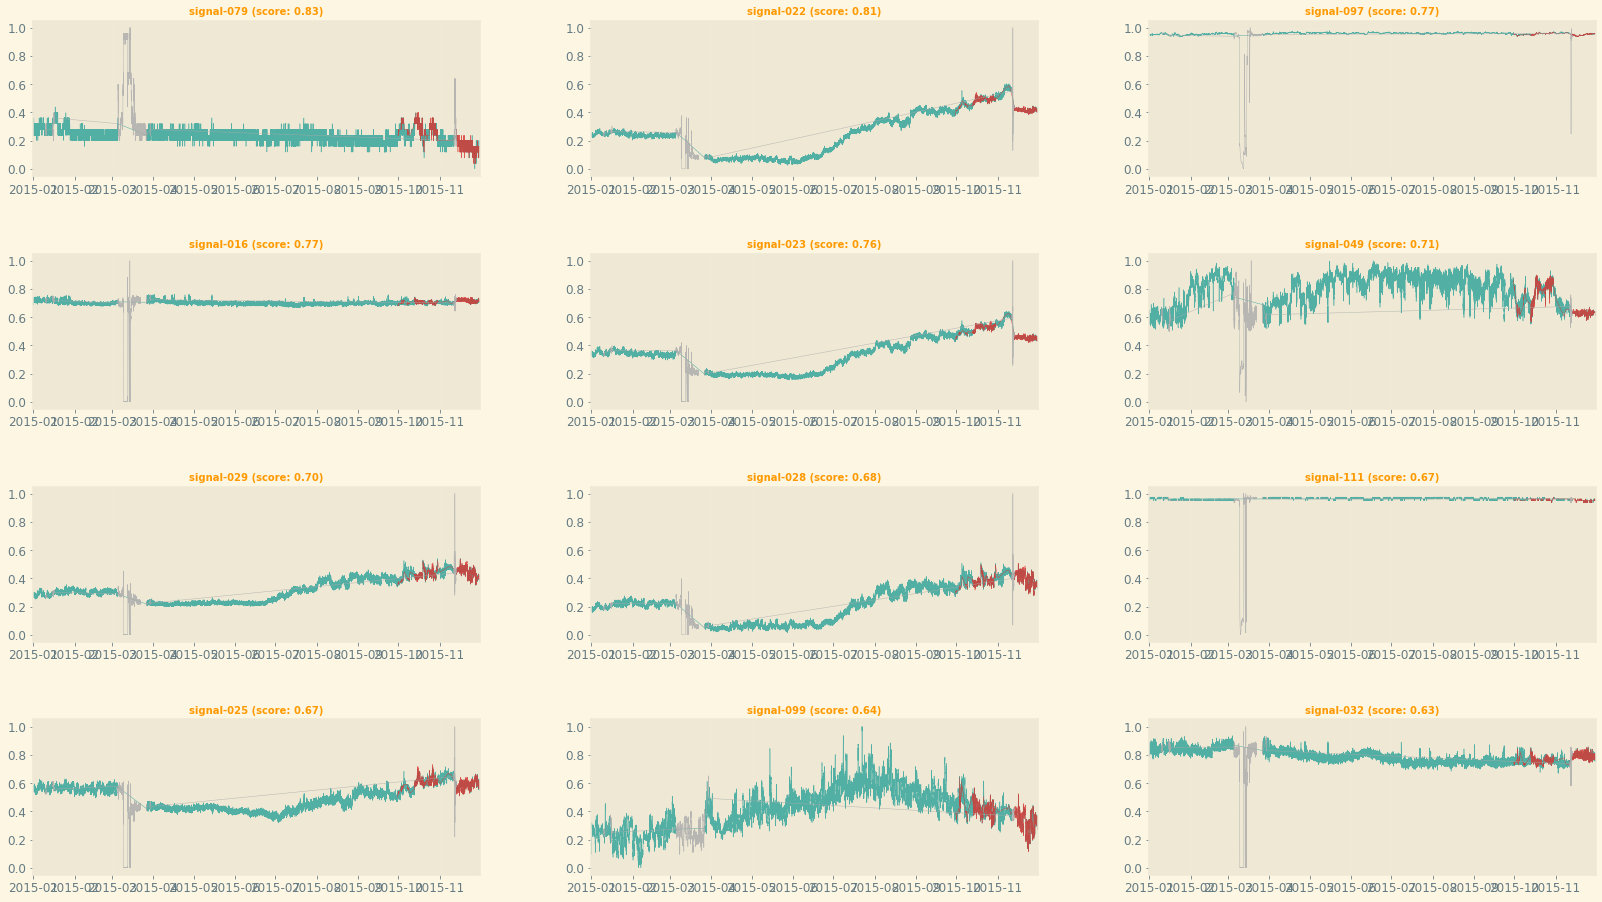

In [12]:
fig, axes = LookoutDiagnostics.plot_signals()

Let's now extract a list of these signals:

In [13]:
LookoutDiagnostics.get_ranked_list()

,Tag,Rank
0,signal-079,0.827683
1,signal-022,0.813001
2,signal-097,0.772627
3,signal-016,0.765132
4,signal-023,0.761360
5,signal-049,0.711678
6,signal-029,0.695862
7,signal-028,0.682249
8,signal-111,0.670763
9,signal-025,0.667643


## Conclusion
---
In this notebook, we use the model created in part 3 of this notebook series and performed a few visualization and diagnostics on the results obtained. You can now move forward to the next step to the **inference scheduling notebook** where we will start the model, feed it some new data and catch the results.